In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

from pythia.timeseries.lombscargle import LS_periodogram

In [108]:
# This does work
# The data is not normalized
search = lk.search_lightcurve('U Gru', cadence=120)
lc = search[-1].download().remove_nans().remove_outliers()#.normalize()
time = lc.time.value
flux = lc.flux.value

# This doesn't work 
# This data is normalized to 1
#time, flux = np.loadtxt('../data/ugru.dat').T


Let's take a look at the raw data

<IPython.core.display.Javascript object>


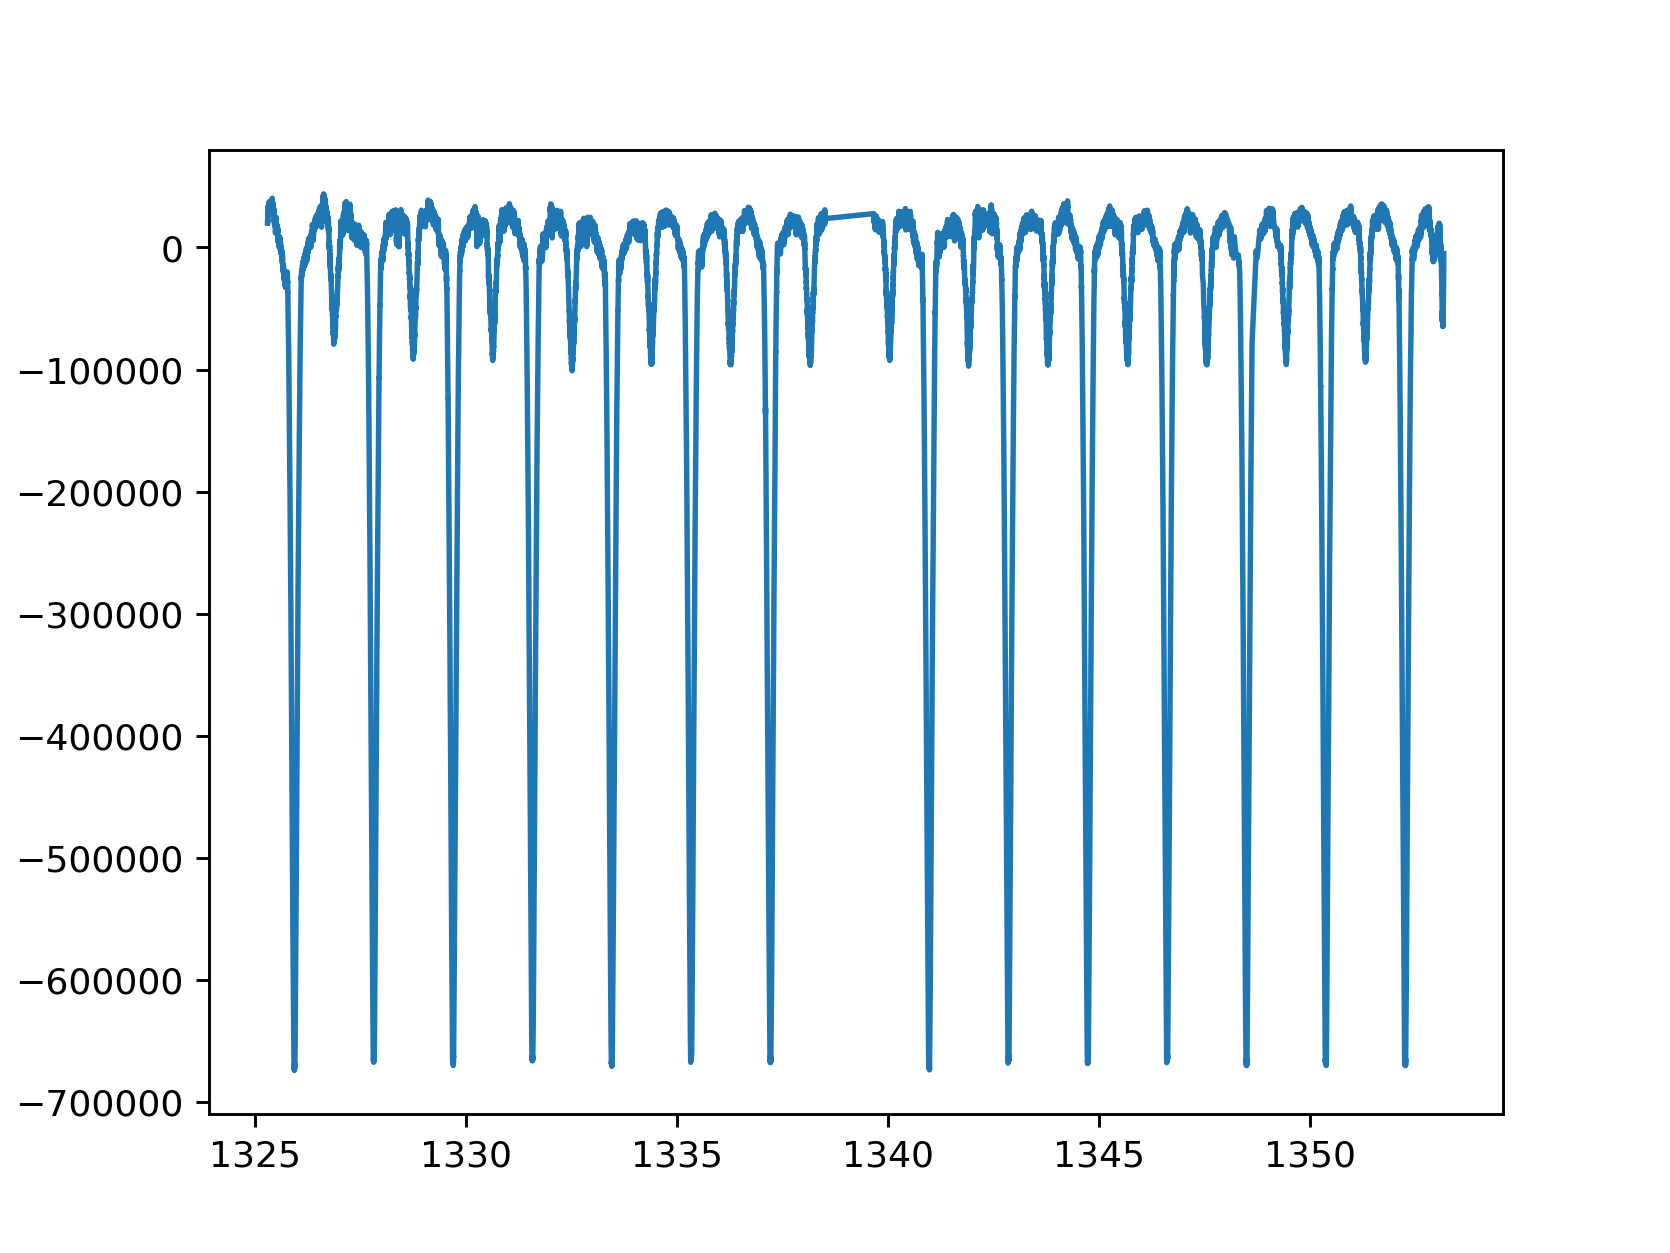

In [94]:
fig_lc, ax_lc = plt.subplots(num=1)
plt.plot(time, flux)

And now let's look at the periodogram

<IPython.core.display.Javascript object>


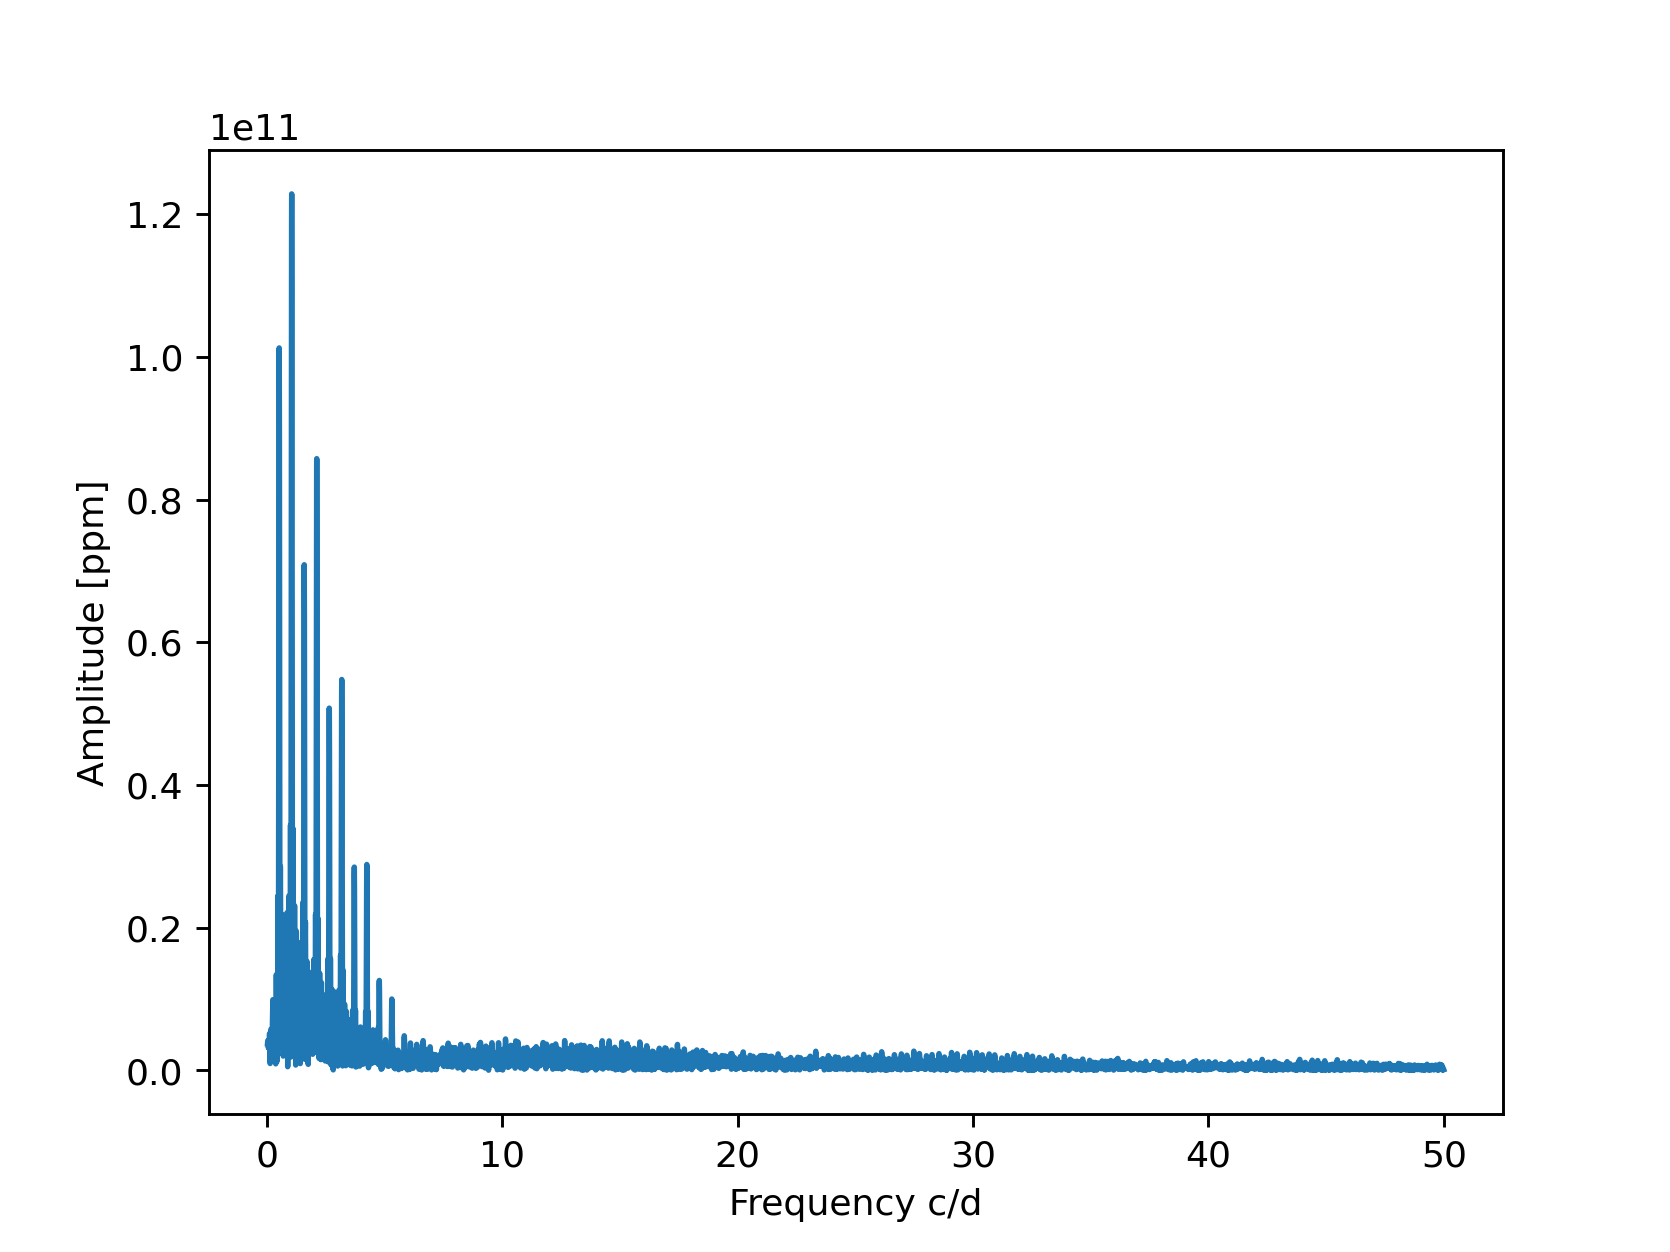

Text(0, 0.5, 'Amplitude [ppm]')

In [95]:
nu, amp = LS_periodogram(time, flux-np.median(flux), max=50)
fig, ax = plt.subplots(num=2)
ax.plot(nu, amp*1e6)
ax.set_xlabel('Frequency c/d')
ax.set_ylabel('Amplitude [ppm]')

Good - we can't see anything except for harmoinics. 
This is exactly what we want to fix!

Below, we have some functions that create a design matrix
with a Fourier basis and we use that to solve for a linear
model that predicts the sum-total of the binary behaviour 
that is described by a harmonic series.

In [109]:
period = 1.8805

In [110]:
def design_matrix(x, period, n_harmonics):
    omegas = 2. * np.pi * np.arange(1, n_harmonics + 1) / period
    X = np.ones((len(x), 2 * n_harmonics))
    X[:,::2] = np.cos(omegas[None, :] * x[:, None]) # I'm dyin heah ## original hogg quote, will not be removing.
    X[:,1::2] = np.sin(omegas[None, :] * x[:, None])
    return X


def solve_ridgeRegression(x, y, period, K, alpha):
    X = design_matrix(x, period, K)
    wI = np.eye(X.shape[1])
    wI[0,0] = 0
    betas_w = np.linalg.solve( alpha*wI + X.T@X, X.T @ y)
    return betas_w

def solve_simple(x, y, period, K):

    X = design_matrix(x, period, K)
    betas = np.linalg.solve(X.T @ X, X.T @ y)
    # amps, resids, rank, S = np.linalg.lstsq(X, flux, rcond=None)

    return betas

def generate_synthetic_data(x, y, period, K):
    X = design_matrix(x, period, K)
    betas = solve_simple(x, y, period, K)
    reconstructed_y = X @ betas
    return X, betas, reconstructed_y

In [111]:
K = 150

X = design_matrix(time, period, K)

# Do this with a simple linear regression
amps = solve_simple(time, flux, period, K)

# Now, let's try a Ridge Regression because why not
amps_w = solve_ridgeRegression(time, flux, period, K, 10)
# amps, resids, rank, S = np.linalg.lstsq(X, flux, rcond=None)

In [112]:
# Reconstruct the predicted flux based on our linear models
predicted_flux = X @ amps
predicted_wflux = X @ amps_w
resid = flux - predicted_flux
resid_w = flux - predicted_wflux

In [113]:
# Now we want to calculate a periodogram of the residuals and see
# if we can identify any new features (i.e., pulsations) that 
# were previously hiding under the harmonic forest from the binary

nu, amp = LS_periodogram(time, resid-np.median(resid), max=50)
nu_w, amp_w = LS_periodogram(time, resid_w-np.median(resid_w), max=50)
# print(resid, amp)

<IPython.core.display.Javascript object>


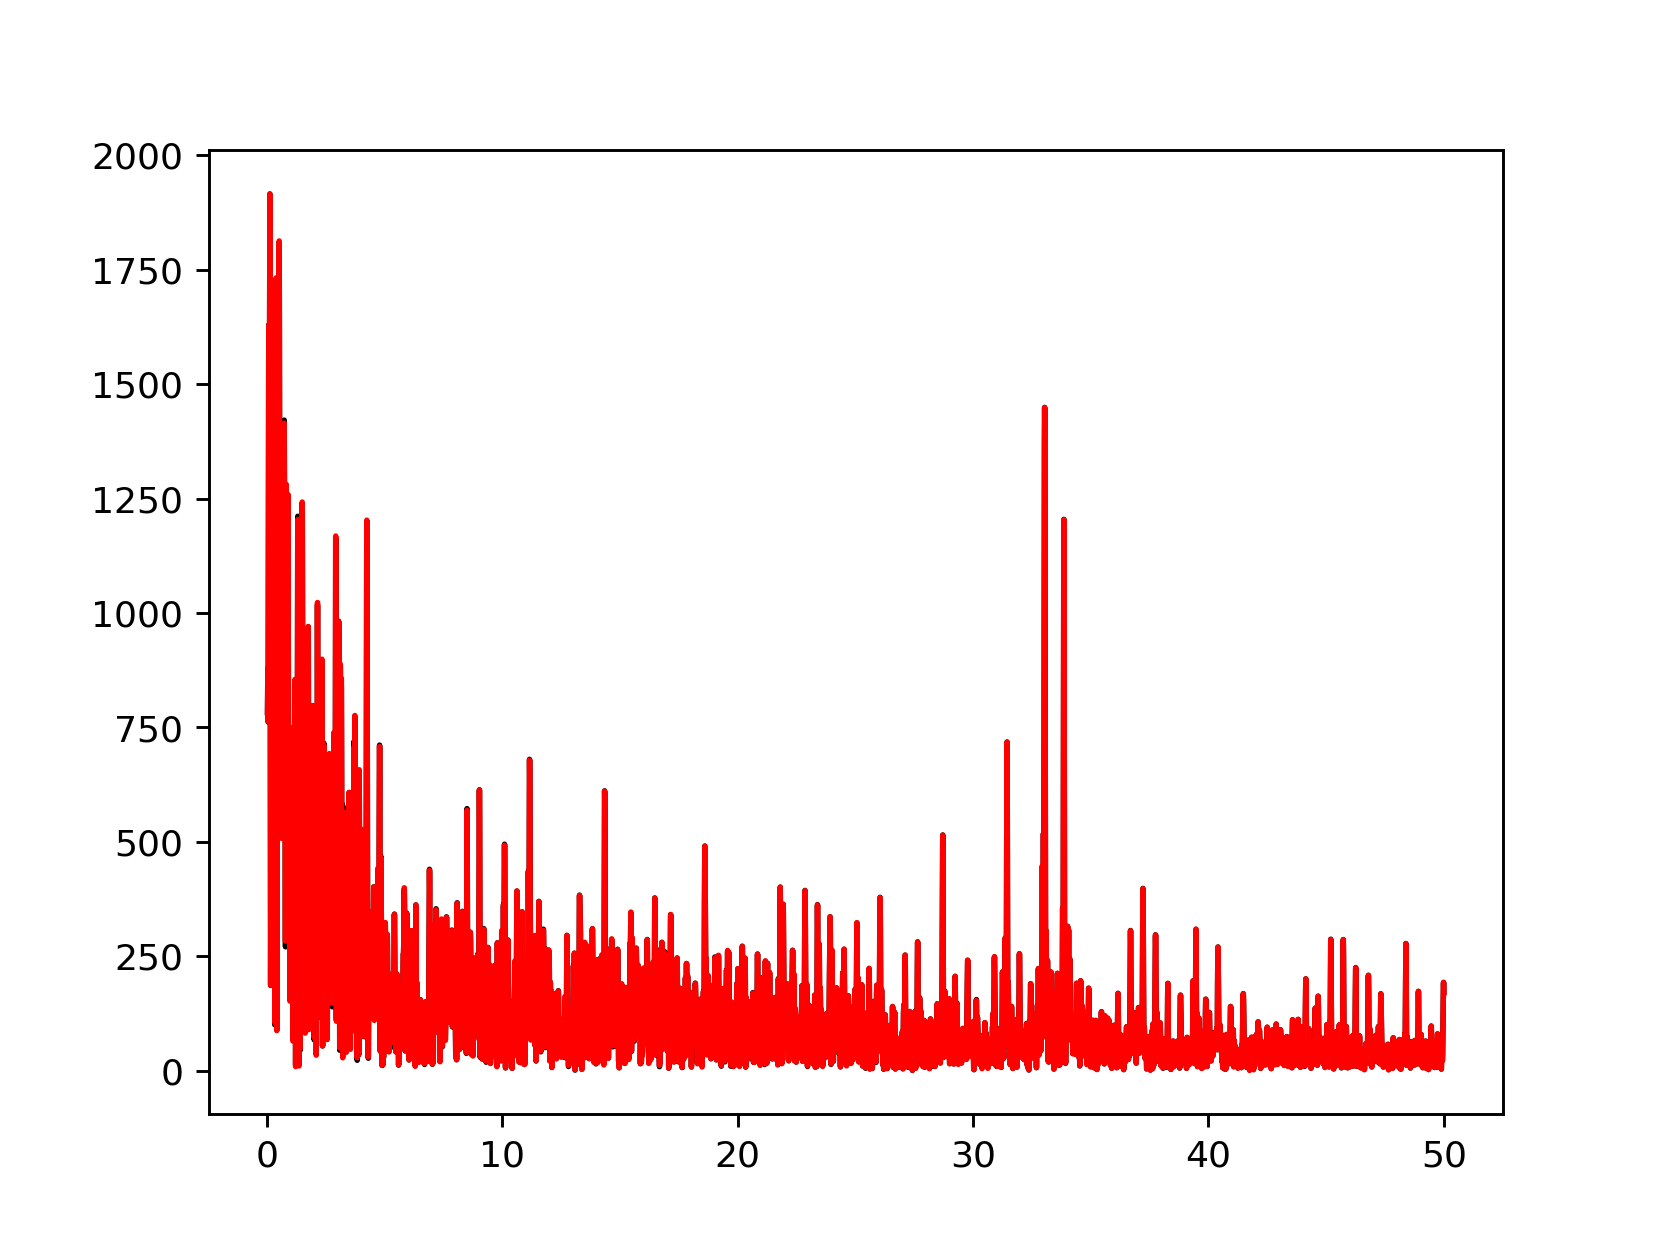

In [114]:
fig_, ax_ = plt.subplots(num=7)
ax_.plot(nu, amp, 'k')
ax_.plot(nu_w, amp_w, 'r')

So, we see something - but it's not perfect. There is still a lot of residual power in harmonics of the binary frequency, but both the simple
linear regression and the Ridge Regression give the same answer. 

We might have to get creative with improving this. Is the problem in the sharp features around eclipse?

<IPython.core.display.Javascript object>


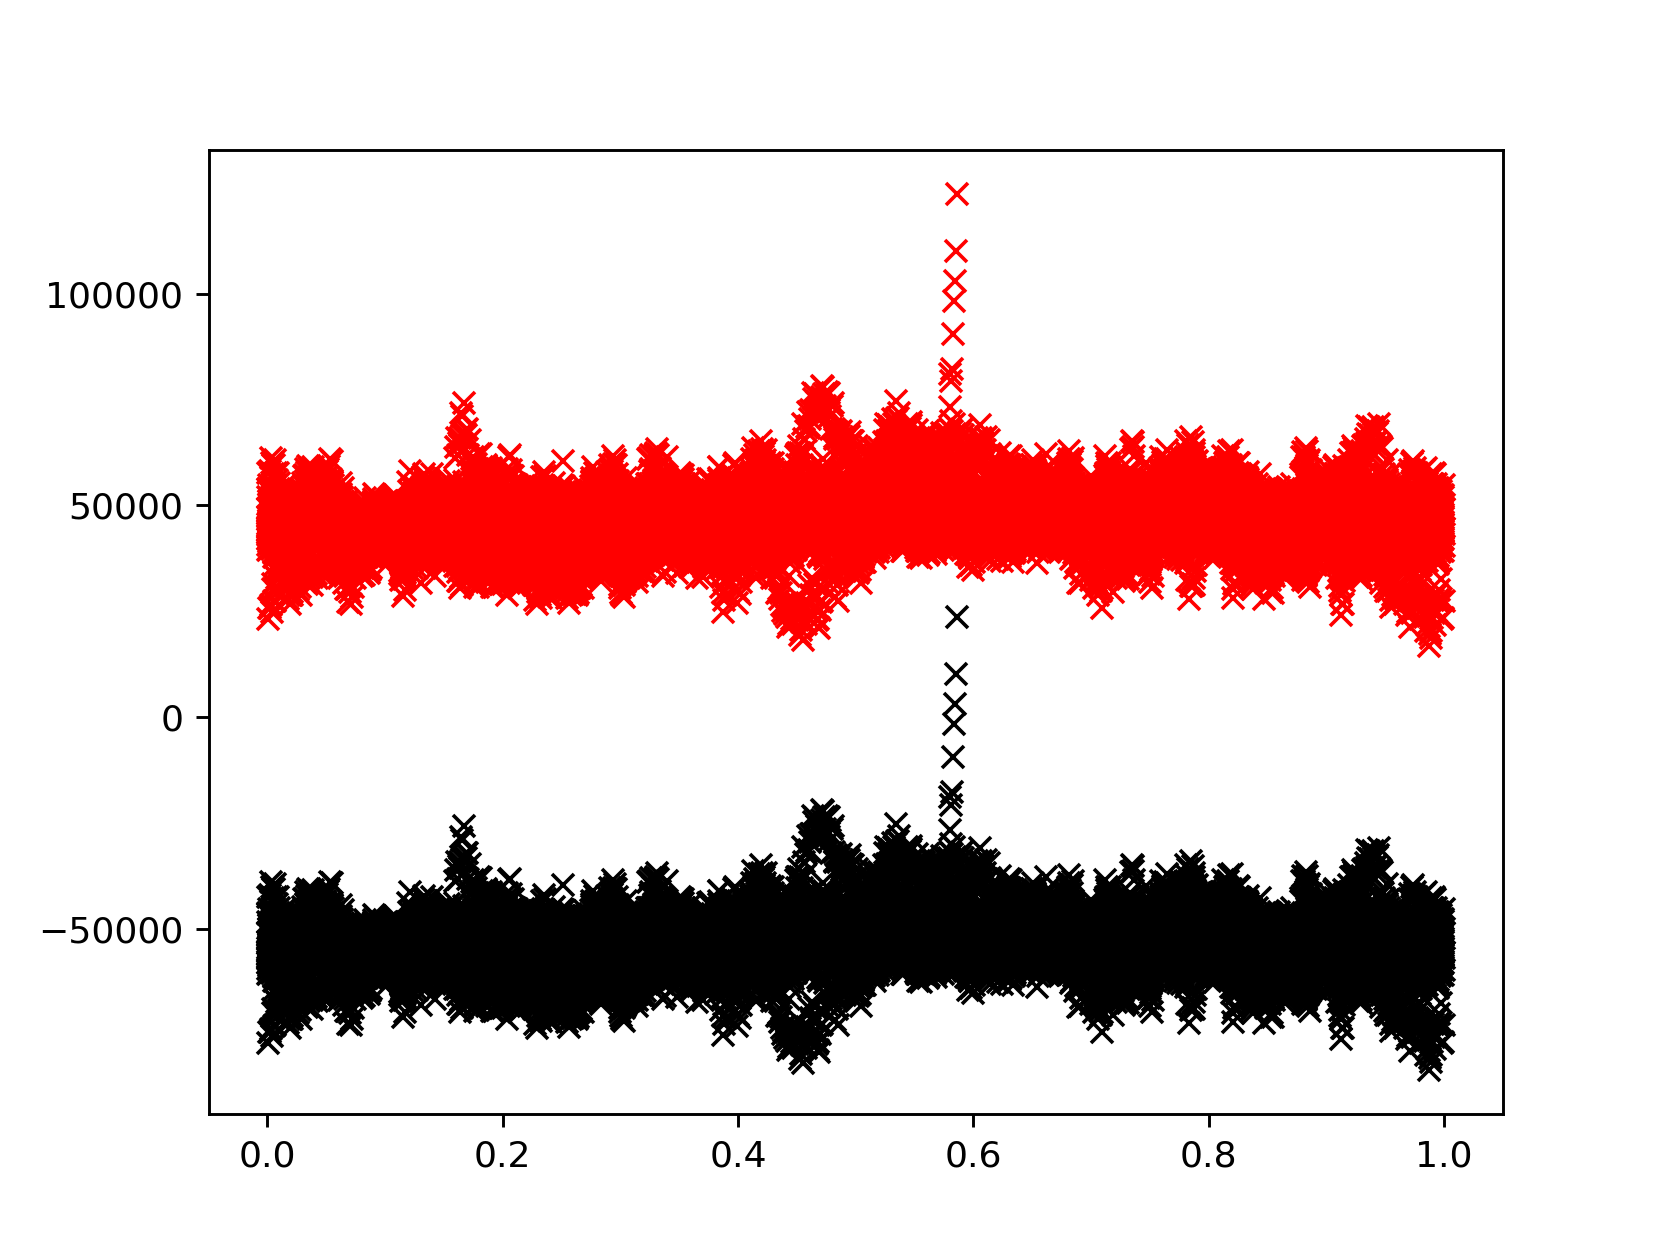

In [118]:
fig_, ax_ = plt.subplots(num=8)
ph = (time/period)%1
ax_.plot(ph, flux-predicted_flux, 'kx')
ax_.plot(ph, flux-predicted_wflux+1e5, 'rx')